<a href="https://colab.research.google.com/github/AndySCS/ZW02a-25_FYP_repo/blob/main/ffn_test/jpnb/FYP_MNIST_MODEL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [11]:
#import pkgs
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch import nn
import torchvision as TV
from IPython.display import clear_output
from torchvision.transforms import ToTensor

#download dataset

In [12]:
train_data = TV.datasets.MNIST(root="data", train=True, transform=ToTensor(), download=True)
test_data = TV.datasets.MNIST(root="data", train=False, transform=ToTensor(), download=True)

In [23]:
from torch.utils.data import DataLoader

batch_size = 32

train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_dataloader  = DataLoader(test_data,  batch_size=batch_size, shuffle=False)

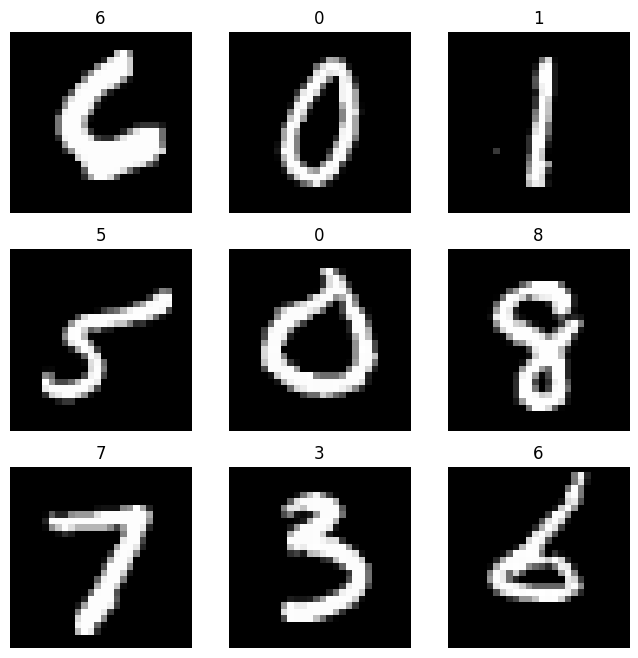

In [14]:
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(train_data), size=(1,)).item()
    img, label = train_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(label)
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

#get device

In [15]:
device = torch.accelerator.current_accelerator().type if torch.accelerator.is_available() else "cpu"
print(f"Using {device} device")

Using cpu device


#define model class

In [24]:
class NeuralNetwork(nn.Module):
  def __init__(self):
      super().__init__()
      self.flatten = nn.Flatten()
      self.linear_relu_stack = nn.Sequential(
          nn.Linear(28*28, 128),
          nn.ReLU(),
          nn.Dropout(p=0.5),
          nn.Linear(128, 10),
      )

  def forward(self, x):
      x = self.flatten(x)
      logits = self.linear_relu_stack(x)
      #logits = nn.functional.log_softmax(logits, dim=1)
      return logits

In [25]:
model = NeuralNetwork().to(device)
print(model)

NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=128, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.5, inplace=False)
    (3): Linear(in_features=128, out_features=10, bias=True)
  )
)


#train the model

In [18]:
learning_rate = 1e-3

In [19]:
def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)  # if using GPU later

        pred = model(X)
        loss = loss_fn(pred, y)

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if batch % 100 == 0:
            loss_val = loss.item()
            current = (batch + 1) * len(X)
            print(f"loss: {loss_val:>7f}  [{current:>5d}/{size:>5d}]")


def test_loop(dataloader, model, loss_fn):
    # Set the model to evaluation mode - important for batch normalization and dropout layers
    # Unnecessary in this situation but added for best practices
    model.eval()
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    # Evaluating the model with torch.no_grad() ensures that no gradients are computed during test mode
    # also serves to reduce unnecessary gradient computations and memory usage for tensors with requires_grad=True
    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (torch.softmax(pred, dim=1).argmax(1) == y).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [26]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

epochs = 20
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(train_dataloader, model, loss_fn, optimizer)
    test_loop(test_dataloader, model, loss_fn)
print("Done!")

Epoch 1
-------------------------------
loss: 2.316027  [   32/60000]
loss: 2.316411  [ 3232/60000]
loss: 2.280066  [ 6432/60000]
loss: 2.258033  [ 9632/60000]
loss: 2.196616  [12832/60000]
loss: 2.188686  [16032/60000]
loss: 2.169679  [19232/60000]
loss: 2.170967  [22432/60000]
loss: 2.169399  [25632/60000]
loss: 2.102888  [28832/60000]
loss: 2.149658  [32032/60000]
loss: 2.176952  [35232/60000]
loss: 2.018304  [38432/60000]
loss: 2.068750  [41632/60000]
loss: 1.890656  [44832/60000]
loss: 2.041049  [48032/60000]
loss: 1.996663  [51232/60000]
loss: 1.908328  [54432/60000]
loss: 1.858690  [57632/60000]
Test Error: 
 Accuracy: 70.8%, Avg loss: 1.848635 

Epoch 2
-------------------------------
loss: 1.858081  [   32/60000]
loss: 1.869843  [ 3232/60000]
loss: 1.848228  [ 6432/60000]
loss: 1.800400  [ 9632/60000]
loss: 1.770746  [12832/60000]
loss: 1.672353  [16032/60000]
loss: 1.627401  [19232/60000]
loss: 1.657145  [22432/60000]
loss: 1.769796  [25632/60000]
loss: 1.561606  [28832/60000

#save model

In [21]:
torch.save(model.state_dict(), 'model.pth')

In [22]:
from google.colab import files
files.download("model.pth")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

#quant model

In [31]:
import torch.ao.quantization as quant

# 2. Specify quantization configuration
model.qconfig = quant.get_default_qconfig("fbgemm")  # backend for x86 CPUs
# 3. Prepare model for calibration
prepared_model = quant.prepare_fx(model, {"": model.qconfig})

AttributeError: module 'torch.ao.quantization' has no attribute 'prepare_fx'